# Data Wrangling on Time Series Datasets

Data wrangling in time series datasets usually consists of 4 main steps:
- Analyze Missing Data
- Align timescales using up/downsampling
- Perform smoothing
- Extract seasonality

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Set tick interval to years
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, steps=[2]))

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Set tick interval to years
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, steps=[2]))

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [58]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


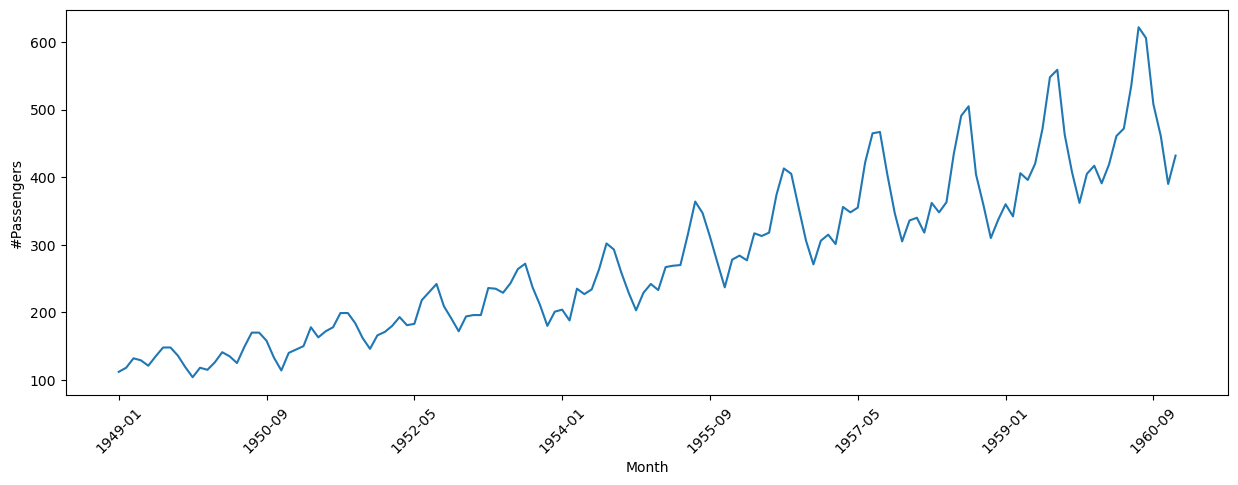

In [59]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

## 0.2 Air Quality Dataset

In [65]:
# Initial loading - Separator is different here
AirQualityUCI = pd.read_csv("./datasets/AirQualityUCI.csv", sep=";")

# Convert date_column to datetime format
AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])

# Convert time_column to timedelta format
AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))

# Merge both fields
AirQualityUCI['DateTime'] = AirQualityUCI['Date'] + AirQualityUCI['Time']

# Drop columns
AirQualityUCI = AirQualityUCI.drop(['Date', 'Time'], axis=1)

# Reformat columns
cols = ['CO(GT)', 'T', 'RH', 'AH']
for col in cols:
    AirQualityUCI[col] = AirQualityUCI[col].str.replace(",", ".").astype('float').replace(-200, None)

# Take only an interval of dates
start_date = "23-03-2004"
end_date = "01-03-2005"
AirQualityUCI = AirQualityUCI.loc[(AirQualityUCI['DateTime'] >= start_date) & (AirQualityUCI['DateTime'] <= end_date)]

AirQualityUCI.head()

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_11798/3371991312.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_11798/3371991312.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_11798/3371991312.py:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI = Ai

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,DateTime
0,2.6,1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-10-03 18:00:00
1,2.0,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-10-03 19:00:00
2,2.2,1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-10-03 20:00:00
3,2.2,1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-10-03 21:00:00
4,1.6,1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-10-03 22:00:00


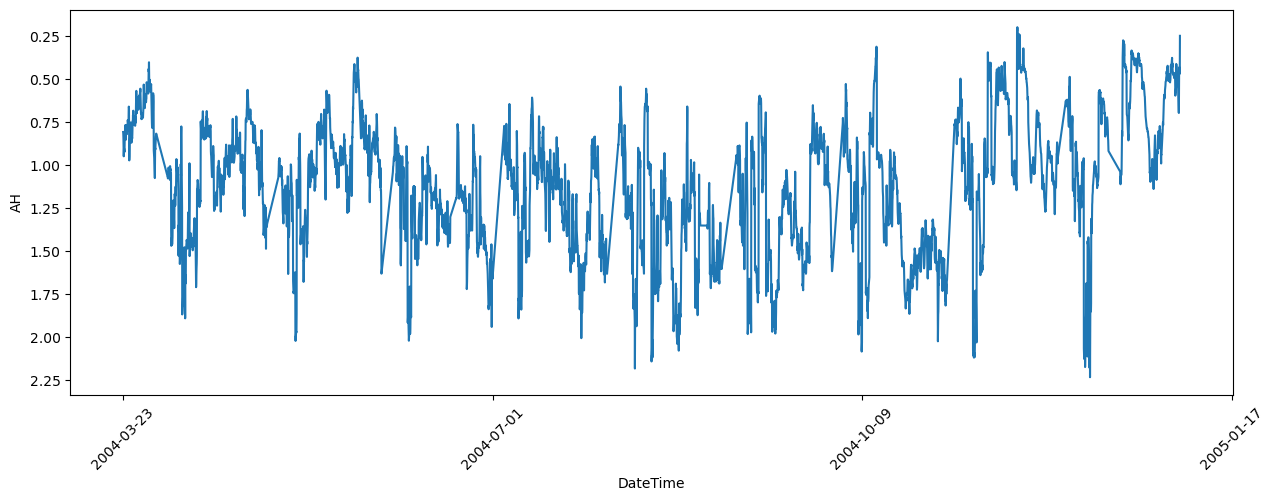

In [66]:
plot_lineplot_time_series(AirQualityUCI, "DateTime", "AH")

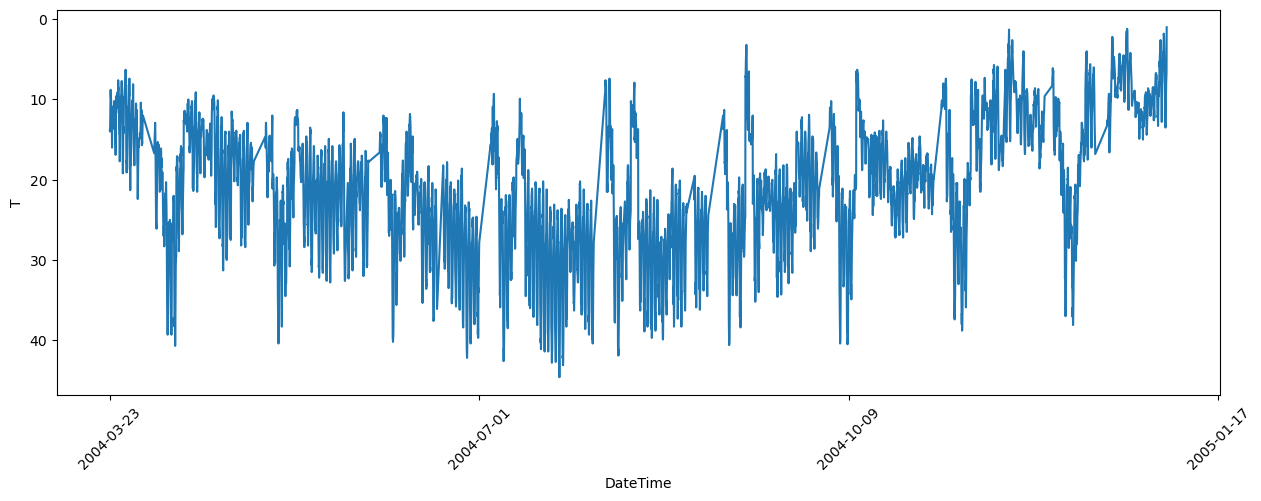

In [67]:
plot_time_series(AirQualityUCI, "DateTime", "T")

# 1. Analyze Missing Data

For this example, I will use the AirQuality dataset, with the variable T (Temperature).

I will use two strategies:
- Forward-fill
- Moving Average

The difference is not significant here. However, because this variable is really noisy, I would go for a moving average.

In [81]:
# Forward Fill
AirQualityUCI["T_FFill"] = AirQualityUCI['T'].fillna(method='ffill')

In [82]:
# Moving Average - Window of 5
AirQualityUCI["T_MovingAv"] = AirQualityUCI['T'].fillna(AirQualityUCI['T'].rolling(window=5, min_periods=1).mean())

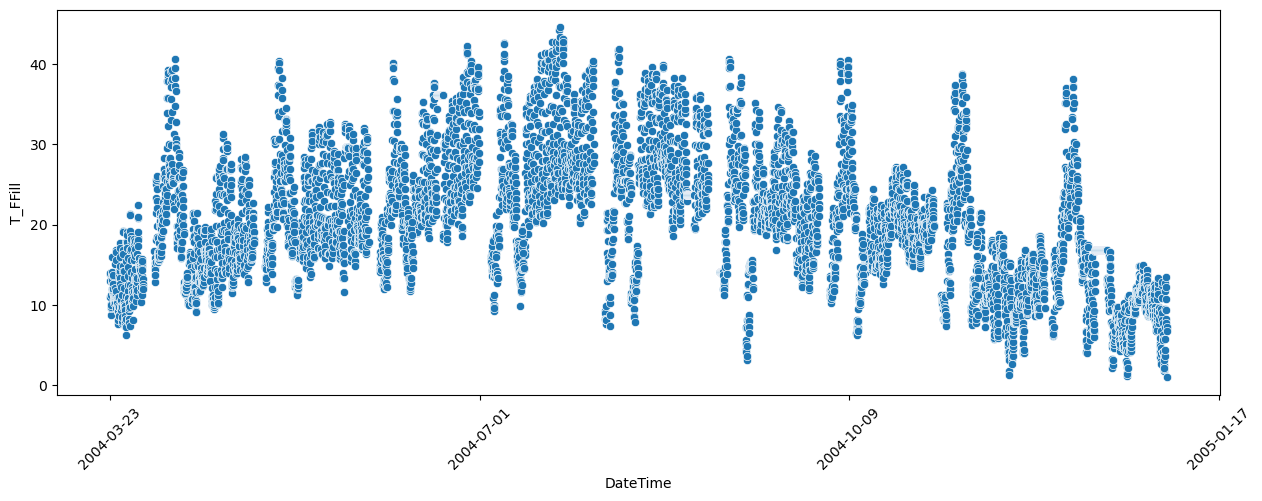

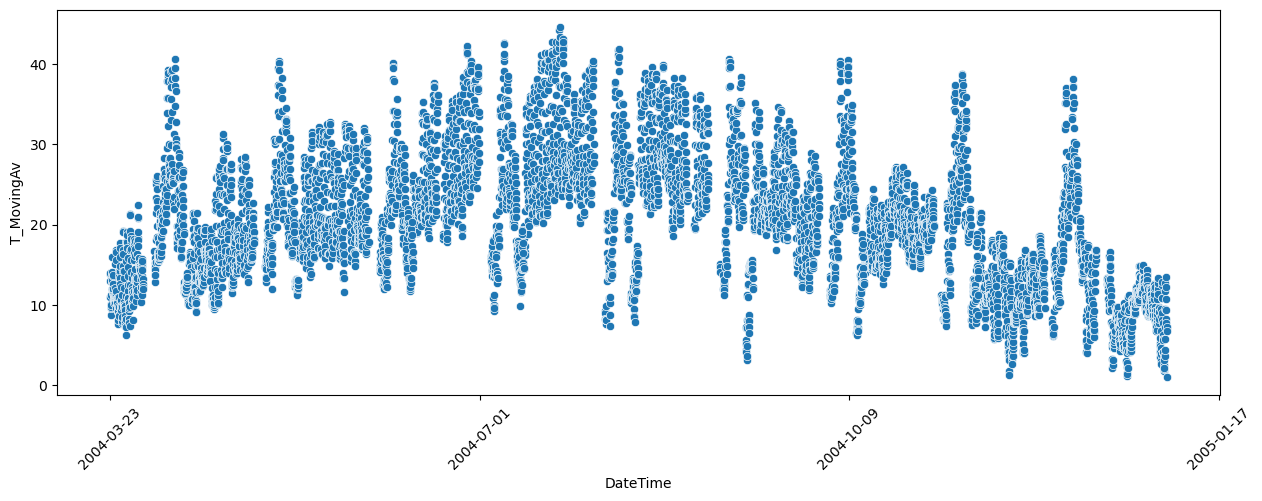

In [84]:
# Plot both results
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T_FFill")
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T_MovingAv")